# Setting the Path

In [ ]:
import numpy as np
import glob
import os
from pathlib import Path
from keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/ML_dataset"

cats  dogs  horses  humans


In [ ]:
p = Path("/content/drive/My Drive/ML_dataset/")
dirs = p.glob("*")
labels_dict = {"cat":0, "dog":1, "horse":2, "human":3}

In [ ]:
img_data = []
labels = []

for folder_dir in dirs:
  label = str(folder_dir).split("/")[-1][:-1]


  for img_path in folder_dir.glob("*.jpg"):
    img = image.load_img(img_path, target_size=(32,32))
    img_array = image.img_to_array(img)
    img_data.append(img_array)
    labels.append(labels_dict[label])


In [ ]:
print(len(img_data))
print(len(labels))

808
808


In [ ]:
img_data = np.array(img_data, dtype='float32')/255.0
labels = np.array(labels)

print(img_data.shape, labels.shape)

(808, 32, 32, 3) (808,)


## Randomly shuffle the data

In [ ]:
import random
combined = list(zip(img_data, labels))
random.shuffle(combined)

#unzip
img_data[:],labels[:] = zip(*combined)

In [ ]:
### Visualize this data

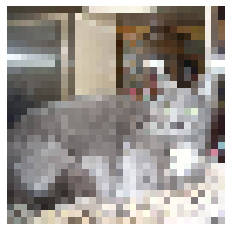

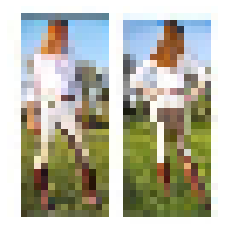

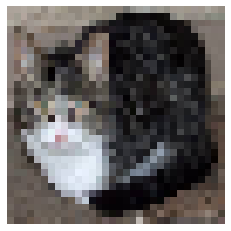

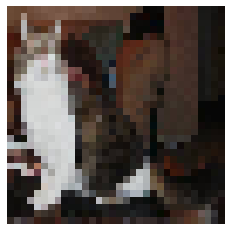

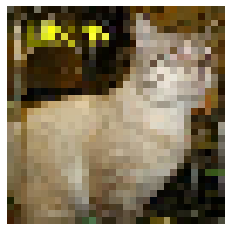

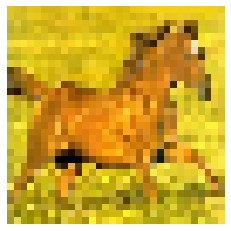

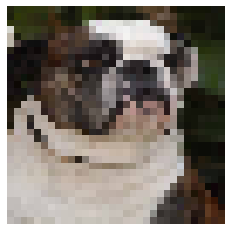

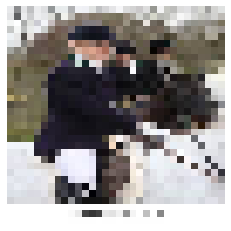

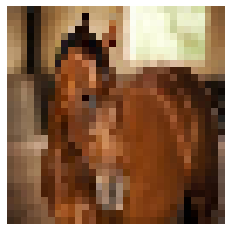

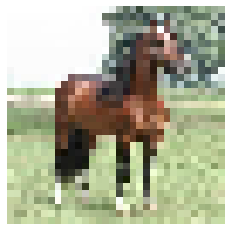

In [ ]:
def drawImg(img):
  from matplotlib import pyplot as plt
  plt.imshow(img)
  plt.axis("off")
  plt.show()
  return

for i in range(10):
  drawImg(img_data[i])

# SVM Classifier

In [ ]:
class SVM:
  def __init__(self, C=1.0):
    self.C = C
    self.W = 0
    self.b = 0

  def hingeLoss(self, W, c, X, Y):
    loss = 0.0
    loss += 0.5*np.dot(W, W.T)
    m = X.shape[0]

    for i in range(m):
      ti = Y[i]*(np.dot(W, X[i].T)+self.b)
      loss += self.C *max(0, (1-ti))

    return loss[0][0]

  def fit(self, X, Y, batch_size=100, learning_rate=0.001, maxItr=300):

    no_of_features = X.shape[1]
    no_of_samples = X.shape[0]

    n = learning_rate
    c = self.C

    W = np.zeros((1,no_of_features))
    bias = 0

    losses = []

    for i in range(maxItr):

      l = self.hingeLoss(W, bias, X, Y)
      losses.append(l)
      ids = np.arange(no_of_samples)

      for batch_start in range(0, no_of_samples, batch_size):
        gradw = 0
        gradb = 0

        for j in range(batch_start, batch_start+batch_size):
          if j<no_of_samples:
            i = ids[j]
            ti = Y[i]*(np.dot(W, X[i].T)+bias)

            if ti>1:
              gradw += 0
              gradb += 0
            else:
              gradw += c*Y[i]*X[i]
              gradb += c*Y[i]
      

        W = W - n*W + n*gradw
        bias = bias + n*gradb

    self.W = W
    self.b = bias

    return W, bias, losses



# We need to convert for one one classification

In [ ]:
M = img_data.shape[0]
img_data = img_data.reshape(M, -1)
print(img_data.shape)
print(labels.shape)

(808, 3072)
(808,)


In [ ]:
CLASSES = len(np.unique(labels))
print(CLASSES)

4


In [ ]:
def classWiseData(x, y):
  data = {}

  for i in range(CLASSES):
    data[i] = []

  for i in range(x.shape[0]):
    data[y[i]].append(x[i])

  for k in data.keys():
    data[k] = np.array(data[k])

  return data

data = classWiseData(img_data, labels)

print(data[0].shape[0])
print(data[1].shape[0])
print(data[2].shape[0])
print(data[3].shape[0])

202
202
202
202


In [ ]:
def getDataPairForSVM(d1, d2):
  # combines data of 2 classes into 1 matrix
  l1, l2 = d1.shape[0], d2.shape[0]

  samples = l1+l2
  features = d1.shape[1]

  data_pair = np.zeros((samples, features))
  data_labels = np.zeros((samples,))

  data_pair[:l1, :] = d1
  data_pair[l1:, :] = d2

  data_labels[:l1] = -1
  data_labels[l1:] = +1

  return data_pair, data_labels

# Training nc2 classifiers SVM 

[404.0, 403.42255621140936, 402.6647342793549, 401.9069595389356, 401.149231986861, 400.21109735893157, 399.2730187753919, 398.3349962325257, 397.3970297266183, 396.6395734835098, 395.70171001, 394.7639025627554, 394.18164996210675, 392.9575253206807, 392.5444316573633, 391.4954884599976, 390.6156572043814, 389.9162948378542, 388.8265453266575, 388.12728915295077, 387.2180620281962, 386.46053768529725, 385.70305925947684, 384.7652103753457, 384.0078327409238, 383.25050101383766, 382.31279883125046, 381.8792742067512, 380.9416563611774, 380.15487111256374, 379.36813306163685, 378.5814422052522, 377.794798540263, 377.00820206352444, 376.3896657383398, 375.3991505488738, 374.82563259670957, 374.0114892838541, 373.19739433062085, 372.77598474951793, 372.15973190150834, 371.54351736316676, 370.9273411318274, 370.31726509513004, 369.7233755305973, 368.61395186534423, 368.26172305440645, 367.4112608249502, 367.3133157063737, 366.2031380270932, 366.177175943383, 365.08627418705504, 364.9265462

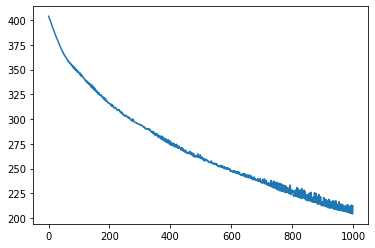

In [ ]:
import matplotlib.pyplot as plt

mySVM = SVM()
xp, yp = getDataPairForSVM(data[0], data[1])
w,b,loss = mySVM.fit(xp,yp,  learning_rate=0.00001, maxItr=1000)
# print(loss)
plt.plot(loss)

In [ ]:
def trainSVMs(x,y):
  svm_classifiers = {}
  for i in range(10):
    svm_classifiers[i] = {}
    for j in range(i+1, CLASSES):
      xpair, ypair = getDataPairForSVM(data[i], data[j])
      wts,b,loss = mySVM.fit(xpair, ypair, learning_rate=0.00001, maxItr=1000)
      svm_classifiers[i][j] = (wts,b)

      plt.plot(loss)
      plt.show()

  return svm_classifiers

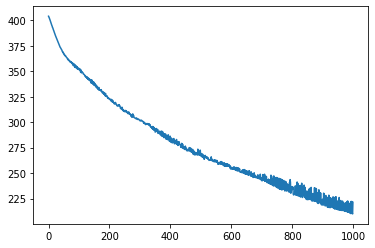

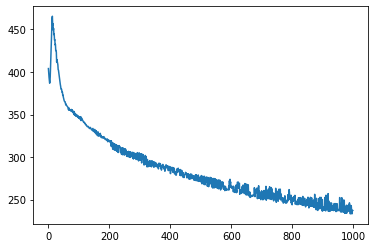

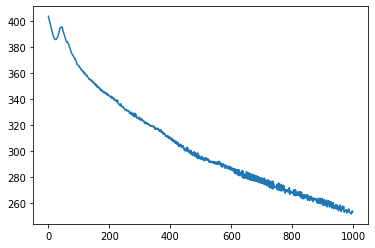

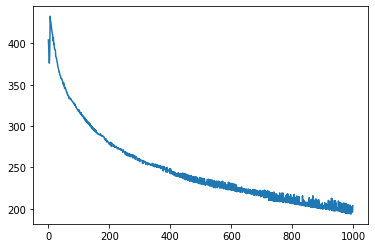

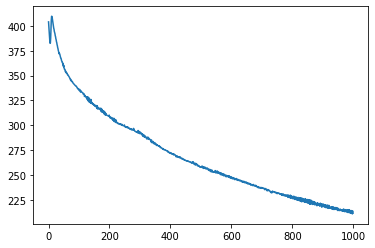

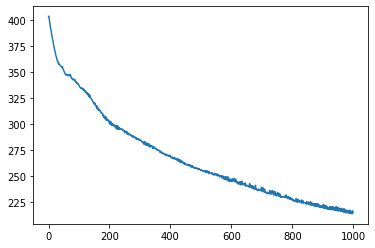

In [ ]:
svm_classifiers = trainSVMs(img_data, labels)

In [ ]:
cats_dogs = svm_classifiers[0][1]
cats_humans = svm_classifiers[0][3]
print(cats_dogs[0].shape)
print(cats_dogs[1].shape)

(1, 3072)
()


## Prediction

In [ ]:
def binaryPredict(x,w,b):
  z = np.dot(x,w.T) + b
  if (z>=0):
    return 1
  else:
    return -1

In [ ]:
def predict(x):
  count = np.zeros((CLASSES,))

  for i in range(CLASSES):
    for j in range(i+1, CLASSES):
      w,b = svm_classifiers[i][j]
      z = binaryPredict(x,w,b)

      if (z==1):
        count[j] += 1
      else:
        count[i] += 1

  final_prediction =  np.argmax(count)  
  
  return final_prediction




In [ ]:
print(predict(img_data[0]))
print(labels[0])

3
0


In [ ]:
def accuracy(x,y):
  count = 0
  for i in range(x.shape[0]):
    prediction = predict(x[i])
    if (prediction==y[i]):
      count += 1

  return count/x.shape[0]


In [ ]:
accuracy(img_data, labels)

0.5804455445544554

In [ ]:
from sklearn import svm

In [ ]:
svm_classifier = svm.SVC(kernel='linear', C=1.0)

In [ ]:
svm_classifier.fit(img_data, labels)
svm_classifier.score(img_data, labels)

0.6633663366336634